# 20 - Latent Dirichlet Allocation - Ejemplo Topics sobre Noticias


* En el siguiente ejemplo vamos a ver como ***obtener los tenas (Topics) de una serie de artículos (noticias)*** que está etiquetados con un tema (el corpus tiene 20 temas).


* ***IMPORTANTE***: *Esto es aprendizaje no supervisado, por lo que no tenemos que tener en cuentas los temas en los que alguien (un humano experto) ha clasificado estos textos. La idea del ejercico es la de obtener los temas distintos de los que hablan los artículos (***Clusterizar artículos***) y nos es útil saber a priori el número de temas distintos que puede tener, pero en ningún caso el target de los artículos entraria al algoritmo de aprendizaje (LDA en este caso)*


* Para realizar este ejercicio realizaremos los siguientes pasos:
    1. Carga de datos
    2. Normalización de textos
    3. Creacción del diccionario y la bolsa de palabras
    4. Creacción del modelo
    5. Visualización
    6. Selección del número óptimo de Topics (coherencia)
    7. Creacción del modelo y visualización con el número de temas óptimo

<hr>


## Carga de Datos


* El fichero en formato Json contiene una serie de documento en los que le asigna una temática.


* Cada elemento del Json contiene:
    - **content**: Contenido del artículo
    - **target**: Identificador del target
    - **target_names**: Nombre del target
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

df = pd.read_json('./data/newsgroups.json')
corpus = df.content.values
df.sample(5)

,content,target,target_names
10829,From: thompson@apple.com (Paul Thompson)\nSubj...,8,rec.motorcycles
2613,From: nahess@mir.gatech.edu (Nicholas A. Hess)...,1,comp.graphics
11036,From: syck5280@miller.cs.uwm.edu (Steven B Syc...,16,talk.politics.guns
7551,From: Eastgate@world.std.com (Mark Bernstein)\...,9,rec.sport.baseball
9154,From: szabo@techbook.com (Nick Szabo)\nSubject...,14,sci.space


* Los documentos se han clasificado en 20 temas, lo cual nos puede dar una pista para seleccionar el número de temas a priori:

In [2]:
df.groupby(['target', 'target_names']).count()

,,content
target,target_names,
0,alt.atheism,92
1,comp.graphics,120
2,comp.os.ms-windows.misc,122
3,comp.sys.ibm.pc.hardware,138
4,comp.sys.mac.hardware,122
5,comp.windows.x,135
6,misc.forsale,145
7,rec.autos,137
8,rec.motorcycles,118


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Para ***normalizar*** los artículos realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las palabras con mas de 12 caracteres.
    5. Eliminamos las Stop-Words.
    6. Eliminamos los emails
    7. Eliminamos los saltos de linea
    8. Eliminamos las comillas simples
    9. Filtramos las palabras que no sean Nombre, Adjetivo, Verbo o Adverbio
    10. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


In [3]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')


def normalize(corpus):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, doc in enumerate(corpus):
        doc = nlp(doc.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        corpus[index] = " ".join([word.lemma_ for word in doc if (not word.is_punct)
                                  and (len(word.text) > 2) 
                                  and (len(word.text) < 11) 
                                  and (not word.is_stop)
                                  and re.sub('\S*@\S*\s?', '', word.text)
                                  and re.sub('\s+', ' ', word.text)
                                  and re.sub("\'", "", word.text)
                                  and not word.text.startswith('|')
                                  and (word.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])])
        
        
    return corpus

# Normalizamos las frases
corpus_norm = normalize(corpus)

<hr>


## Creacción del diccionario y la bolsa de palabras (BoW)


* En este punto tenemos que crear:
    - Corpus tokenizado: "*documents_tok*"
    - Diccionario: "*dictionary*"
    - Corpus: "*corpus*' que es la bolsa de palabras de gensim

In [4]:
from pprint import pprint
from gensim import corpora
from collections import defaultdict

# Tokenizamos
documents_tok = [word.split() for word in corpus_norm]

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in documents_tok:
    for token in doc:
        frequency[token] += 1
        
documents = [[token for token in doc] for doc in documents_tok]
dictionary = corpora.Dictionary(documents)
print('Diccionario:\n{}'.format(dictionary))


# Creamos la Bolsa de Palabras
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nPrimer Documento del Corpus:\n{}'.format(corpus[0]))

Diccionario:
Dictionary(25194 unique tokens: ['angry', 'bbb', 'bill', 'bureau', 'business']...)

Primer Documento del Corpus:
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


<hr>


## Creacción del modelo


* A priori vamos a crear un modelo con 20 Topics que es el número de temas en los que un humano ha clasificado los texto.


* Dado que estamos trabajando con un corpus relativamente grande (2500 documentos) tenemos que pasarle a la implementación del modelo algunos parámetros para optimizar la ejecución; por ejemplo "chunksize=100" para que vaya entrenando el modelo de 100 en 100 documentos.


* Para más información ver la documentación: https://radimrehurek.com/gensim/models/ldamodel.html

In [5]:
warnings.filterwarnings('ignore')
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=20,
                     random_state=100,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

<hr>


## Visualización


* Pasamos a visualizar los resultados con la librería de '*pyLDAvis*'


* Como los resultados obtenidos podemos observar que hay temas (**topics**) muy similares entre si, ya que las bolas que representan los topics están "apelotonadas" entre sí, lo que significas que esos temas están caracterizados por palabras que son comunes en ambos temas.


* Con esta visualización podemos observar que hay temas muy relacionados entre sí y que probablemente hablen de lo mismo, por lo que deberíamos de seleccionar menos temas.

In [6]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

<hr>


# <span style="color:red">Selección del número óptimo de Topics (coherencia)</span>



* Dado que las técnicas de "*Topic Modeling*" (tanto LSI como LDA) ***generan automáticamente 'N' temas (Topics)*** a partir de los documentos del corpus ***de forma no supervisada***, tenemos que evaluar de alguna manera si los temas que genera son "***Coherentes***" entre sí; es decir, si hay dos o más temas que son tan similares entre sí que podrían formar un tema o si hay temas que son muy genéricos y que podrían dividirse en dos o más temas.


* Este es un problema común que también tenemos las personas a la hora de ***asignar un tema a un texto ya que se trata de una tarea que en ocasiones puede ser muy subjetiva***.


* Por este motívo es necesario cuantificar un nivel de ***Coherencia*** sobre la segmentación realizada.


* Para hacer una analogía con Clustering, la ***Coherencia*** en el Topic Modeling viene a ser como la ***Inercia*** en el K-Means.


* La ***Coherencia*** es por tanto una medida que ***nos sirve para ver lo bien o mal que están definidos los temas (Topics) por sus palabras (Terms) más representativas del Topic***.


* Para más información ver el siguiente artículo: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf


### ¿Como se calcula la Coherencia?


* La coherencia de un modelo se calcula dadas las 'N' palabras más relevantes de un tema (Topic) como:


$$ coherence = \sum_{i>j} score(w_{i},w_{j})$$


* Siendo w<sub>i</sub> y w<sub>j</sub> dos pares de palabras relevantes del tema (Topic).


* Existen dos métodos para el cálculo del ***score*** de la coherencia que son:
    - Extrinsic UCI measure
    - Intrinsic UMass measure
   
   
* Antes de explicar como se calcula el score definimos:

    - **D**: Número de documentos del corpus.
    - **D(w<sub>i</sub>)**: Número de documentos en el que aparece la palabra w<sub>i</sub> en el corpus.
    - **D(w<sub>i</sub>, w<sub>j</sub>)**: Número de documentos en el que aparecen conjuntamente las palabras w<sub>i</sub> y w<sub>j</sub> en el corpus.
    - **p(w<sub>i</sub>)**: Probabilidad de que aparezca la palabra w<sub>i</sub> en un documento del corpus:
    
    $$p(w_{i}) = \frac{D(w_{i})}{D}$$
    
    - **p(w<sub>i</sub>, w<sub>i</sub>)**: Probabilidad de que aparezcan conjuntamente las palabras w<sub>i</sub> y w<sub>j</sub> en un documento del corpus:
    
    $$p(w_{i}, w_{j}) = \frac{D(w_{i}, w_{j})}{D}$$
    
* ***Score: Extrinsic UCI measure***
    
    $$score_{c\_uci} (w_{i}, w_{j}) = log \frac{p(w_{i},w_{j})}{p(w_{i}) p(w_{j})}$$


* ***Score: Intrinsic UMass measure***
    
    $$score_{c\_mass} (w_{i}, w_{j}) = log \frac{D(w_{i},w_{j}) + 1}{D(w_{i})}$$
    
    
* Veamos a continuación como calcular la coherencia para diferentes modelos de LDA que van desde 5 a 30 temas (Topics):

In [7]:
warnings.filterwarnings('ignore')
from gensim.models import CoherenceModel

coherence = []
min_topics = 5
max_topics = 31
for num_topics in range(min_topics, max_topics, 1):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=168,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=documents_tok, dictionary=dictionary, coherence='u_mass')
    coherence.append(coherencemodel.get_coherence())

In [8]:
index = ["Num Topics: {num}".format(num=num) for num in range(min_topics, max_topics, 1)]
pd.DataFrame(coherence, index=index, columns=['Coherence'])

,Coherence
Num Topics: 5,-3.345802
Num Topics: 6,-2.104016
Num Topics: 7,-2.455668
Num Topics: 8,-2.099630
Num Topics: 9,-3.199689
Num Topics: 10,-3.414736
Num Topics: 11,-3.760765
Num Topics: 12,-3.484855
Num Topics: 13,-3.940295
Num Topics: 14,-3.894806


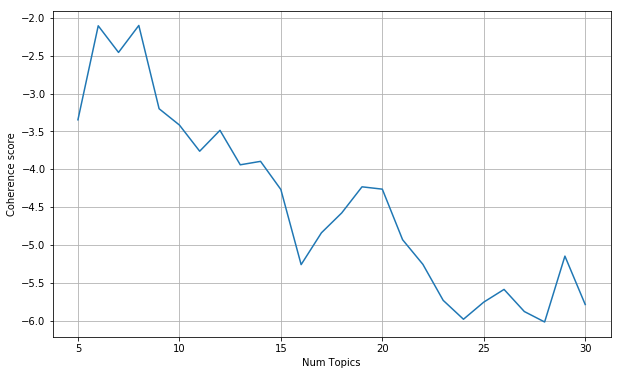

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics, 1), coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid()
plt.show()

<hr>


## Creacción del modelo y visualización con el número de temas óptimo


* Con los resultados obtenidos de la coherencia podemos ver que el mayor valor que obtenemos es para 8 temas, lo que significará que si el corpus lo dividimos en 8 temas (Topics), estos deberían estar caracterizados por palabras (Terms) distintas entre temas.


* Otro resultado interesante de analizar seria el caso de 12 temas (Topics) ya que vemos que tiene un valor de coherencia mayor el el modelo creado para 11 temas, lo cual resulta interesante.


* No existe una norma que diga que la mejor división de temas de un corpus es aquella que mayor valor de coherencia tiene. Cuantos más temas menor coherencia tendremos pero más dividiremos nuestro corpus y viceversa. 


* Por tanto tiene sentido decir que nuestro corpus podría dividirse en 8 o 12 temas diferentes.


* Veamos a continuación como quedaría distribuidos los temas (Topics) y las palabras (Terms).

### Seleccionamos 12 Topics y visualizamos su distribución

In [10]:
warnings.filterwarnings('ignore')

lda_model_12 = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=12,
                        random_state=168,
                        chunksize=100,
                        passes=10,
                        alpha='auto',
                        per_word_topics=True)

vis = pyLDAvis.gensim.prepare(lda_model_12, corpus, dictionary)
pyLDAvis.display(vis)


### Seleccionamos 8 Topics y visualizamos su distribución

In [11]:
warnings.filterwarnings('ignore')

lda_model_8 = LdaModel(corpus=corpus,
                       id2word=dictionary,
                       num_topics=8,
                       random_state=168,
                       chunksize=100,
                       passes=10,
                       alpha='auto',
                       per_word_topics=True)

vis = pyLDAvis.gensim.prepare(lda_model_8, corpus, dictionary)
pyLDAvis.display(vis)
